In [1]:
# Gerekli Kütüphaneleri Yükleyin
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Veri Setini Yükleyin
data = pd.read_csv(r"C:\Users\ALİ CAN ŞAHİN\OneDrive\Masaüstü\VeriSeti2.csv")

Holdout Results:
            Accuracy  Precision    Recall  F1-Score   AUC-ROC
No PCA/LDA  0.805884   0.824360  0.835423  0.829854  0.870471
With PCA    0.778467   0.796052  0.818824  0.807277  0.842101
With LDA    0.800981   0.818481  0.833657  0.825999  0.853568


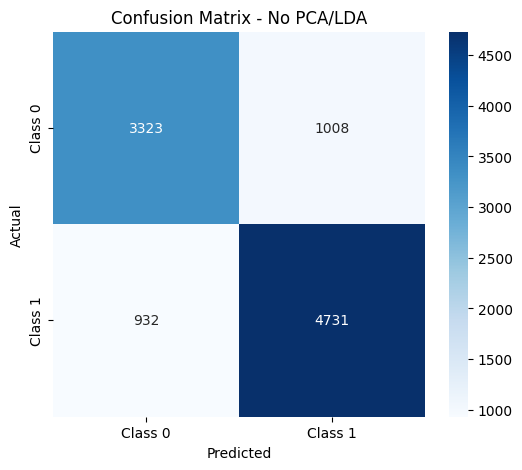

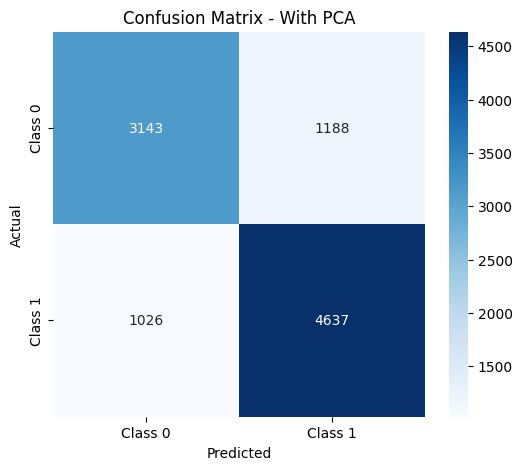

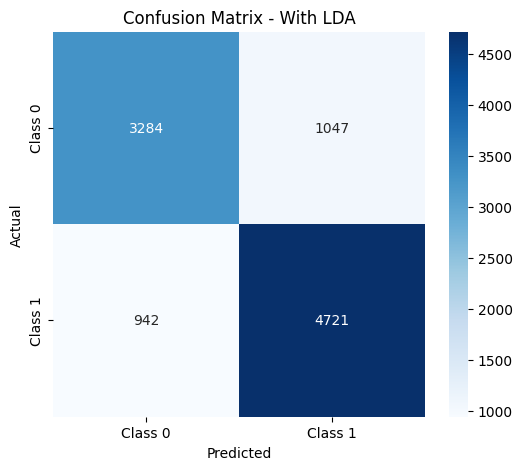


K-Fold Results:
   Accuracy  Precision    Recall  F1-Score   AUC-ROC Model  \
0  0.807730   0.824166  0.839039  0.831536  0.868043  k-NN   
1  0.804503   0.816350  0.844194  0.830038  0.863539  k-NN   
2  0.805914   0.827455  0.832476  0.829958  0.868857  k-NN   
3  0.779887   0.795026  0.822983  0.808763  0.838906  k-NN   
4  0.777561   0.789634  0.826941  0.807857  0.837066  k-NN   
5  0.784074   0.804505  0.819681  0.812022  0.842114  k-NN   
6  0.804428   0.823067  0.833333  0.828168  0.856662  k-NN   
7  0.795647   0.808541  0.836762  0.822409  0.852390  k-NN   
8  0.802387   0.821968  0.833135  0.827514  0.856898  k-NN   

             Reduction  
0  No PCA/LDA (Fold 1)  
1  No PCA/LDA (Fold 2)  
2  No PCA/LDA (Fold 3)  
3         PCA (Fold 1)  
4         PCA (Fold 2)  
5         PCA (Fold 3)  
6         LDA (Fold 1)  
7         LDA (Fold 2)  
8         LDA (Fold 3)  


In [3]:
# Özellik ve Hedef Ayrımı
X = data.drop(columns=['Target_10', 'adjclose'])
y = data['Target_10']

# Ek Özellikler: Momentum ve Trend Göstergeleri
data['Momentum_5'] = data['adjclose'] - data['adjclose'].shift(5)
data['Momentum_10'] = data['adjclose'] - data['adjclose'].shift(10)
data['Trend'] = (data['adjclose'] - data['MA_20']) / data['MA_20']

# Özellik Güncellemesi
X['Momentum_5'] = data['Momentum_5']
X['Momentum_10'] = data['Momentum_10']
X['Trend'] = data['Trend']

# Eksik Değerleri Doldurma
X.fillna(0, inplace=True)

# Eğitim ve Test Setlerine Bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Özellikleri Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA ve LDA Dönüşümleri
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# k-NN Modeli
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Performans Metriklerini Hesaplama
def calculate_metrics(y_true, y_pred, y_pred_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_pred_proba)
    }

# Holdout Sonuçları
knn_clf.fit(X_train_scaled, y_train)
y_pred_no_reduction = knn_clf.predict(X_test_scaled)
y_pred_proba_no_reduction = knn_clf.predict_proba(X_test_scaled)[:, 1]

knn_clf.fit(X_train_pca, y_train)
y_pred_pca = knn_clf.predict(X_test_pca)
y_pred_proba_pca = knn_clf.predict_proba(X_test_pca)[:, 1]

knn_clf.fit(X_train_lda, y_train)
y_pred_lda = knn_clf.predict(X_test_lda)
y_pred_proba_lda = knn_clf.predict_proba(X_test_lda)[:, 1]

# Holdout Metrikleri
holdout_results = {
    "No PCA/LDA": calculate_metrics(y_test, y_pred_no_reduction, y_pred_proba_no_reduction),
    "With PCA": calculate_metrics(y_test, y_pred_pca, y_pred_proba_pca),
    "With LDA": calculate_metrics(y_test, y_pred_lda, y_pred_proba_lda)
}

holdout_df = pd.DataFrame(holdout_results).T
print("Holdout Results:")
print(holdout_df)

# Karışıklık Matrislerini Görselleştirme
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred_no_reduction, "Confusion Matrix - No PCA/LDA")
plot_confusion_matrix(y_test, y_pred_pca, "Confusion Matrix - With PCA")
plot_confusion_matrix(y_test, y_pred_lda, "Confusion Matrix - With LDA")

# K-Fold Çapraz Doğrulama
kf = KFold(n_splits=3)

# K-Fold Sonuçlarını Hesaplama
kfold_results = []

# No PCA/LDA
for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled)):
    X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    knn_clf.fit(X_fold_train, y_fold_train)
    y_fold_pred = knn_clf.predict(X_fold_test)
    y_fold_pred_proba = knn_clf.predict_proba(X_fold_test)[:, 1]

    metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_pred_proba)
    metrics['Model'] = 'k-NN'
    metrics['Reduction'] = f'No PCA/LDA (Fold {fold + 1})'
    kfold_results.append(metrics)

# PCA
for fold, (train_index, test_index) in enumerate(kf.split(X_train_pca)):
    X_fold_train, X_fold_test = X_train_pca[train_index], X_train_pca[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    knn_clf.fit(X_fold_train, y_fold_train)
    y_fold_pred = knn_clf.predict(X_fold_test)
    y_fold_pred_proba = knn_clf.predict_proba(X_fold_test)[:, 1]

    metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_pred_proba)
    metrics['Model'] = 'k-NN'
    metrics['Reduction'] = f'PCA (Fold {fold + 1})'
    kfold_results.append(metrics)

# LDA
for fold, (train_index, test_index) in enumerate(kf.split(X_train_lda)):
    X_fold_train, X_fold_test = X_train_lda[train_index], X_train_lda[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    knn_clf.fit(X_fold_train, y_fold_train)
    y_fold_pred = knn_clf.predict(X_fold_test)
    y_fold_pred_proba = knn_clf.predict_proba(X_fold_test)[:, 1]

    metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_pred_proba)
    metrics['Model'] = 'k-NN'
    metrics['Reduction'] = f'LDA (Fold {fold + 1})'
    kfold_results.append(metrics)

# Sonuçları DataFrame olarak göster
kfold_df = pd.DataFrame(kfold_results)
print("\nK-Fold Results:")
print(kfold_df)